In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/etc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2861825198012854306
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 567379569389014073
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16563613857672789188
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15858476647
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5940789372729165359
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:04:00.0, compute capability: 6.0"
]


In [2]:
from data import *
from model import *
from utilities import *

In [3]:
n = 64 # num of train data == num of val data == num of test data i.e. n*3 <= total num data
batch_size = 4
epochs = 100

print("num train data:", n)
print("num val data: ", n)
print("num test data: ", n)

datasetfilename = str(scale) + "-" + str(patch_size) + "-" + str(framesize) + "-" + str(stride) + "-" + kernel + "-cell2-dataset.p"

img_file_path = []
for filename in glob.iglob('cells/*cell.png'):
    xml = filename.split("cell.png")[0] + "dots.png"
    img_file_path.append([filename, xml])

num train data: 64
num val data:  64
num test data:  64


In [4]:
# load data
np_dataset_x, np_dataset_y, np_dataset_c = data_process(datasetfilename, img_file_path, verbose = False)

reading from preprocessed data:  1-32-256-1-sq-cell2-dataset.p
(3, 200)
(256, 256)
(1, 288, 288)
image data shape:  (200, 256, 256, 1)
ground truth data shape (200, 288, 288, 1)
count data shape (200, 1)


In [22]:
print ("number of counts total ", np_dataset_c.sum())
print ("number of counts on average ", np_dataset_c.mean(), "+-", np_dataset_c.std())
print ("counts min:", np_dataset_c.min(), "max:", np_dataset_c.max())

number of counts total  35124.0
number of counts on average  175.62 +- 57.17329446516092
counts min: 78.0 max: 314.0


In [5]:
# split train-val-test
np_dataset_x_train = np_dataset_x[0:n]
np_dataset_y_train = np_dataset_y[0:n]
np_dataset_c_train = np_dataset_c[0:n]

np_dataset_x_valid = np_dataset_x[n:2*n]
np_dataset_y_valid = np_dataset_y[n:2*n]
np_dataset_c_valid = np_dataset_c[n:2*n]

np_dataset_x_test = np_dataset_x[2*n:3*n]
np_dataset_y_test = np_dataset_y[2*n:3*n]
np_dataset_c_test = np_dataset_c[2*n:3*n]

In [4]:
from keras.callbacks import ModelCheckpoint, TensorBoard

In [49]:
# build model
TRAIN = True
if TRAIN: # train mode
    model = build_model()

    bestcheck = ModelCheckpoint(filepath="model-best.h5", verbose=1, save_weights_only=True, save_best_only=True)
    every10check = ModelCheckpoint(filepath="model-cp.{epoch:02d}-{val_loss:.2f}.h5", verbose=1, period=10, save_weights_only=True)
    tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

    hist = model.fit(np_dataset_x_train, np_dataset_y_train, epochs=epochs, batch_size = batch_size,
                     validation_data = (np_dataset_x_valid, np_dataset_y_valid), 
                     callbacks=[bestcheck, every10check, tbCallBack])

    model.save_weights('model.h5')
else: # test mode
    model = build_model()
    model.load_weights("model-best.h5", by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_15 (ZeroPadding2 (None, 320, 320, 1)  0           input_3[0][0]                    
__________________________________________________________________________________________________
c1_conv (Conv2D)                (None, 318, 318, 64) 640         zero_padding2d_15[0][0]          
__________________________________________________________________________________________________
leaky_re_lu_37 (LeakyReLU)      (None, 318, 318, 64) 0           c1_conv[0][0]                    
__________________________________________________________________________________________________
c1_bn (Bat

Train on 64 samples, validate on 64 samples
Epoch 1/100
64/64 [==============================] - 18s 287ms/step - loss: 2.1949 - acc: 0.0700 - val_loss: 20.6959 - val_acc: 0.0283

Epoch 00001: val_loss improved from inf to 20.69588, saving model to model-best.h5
Epoch 2/100
64/64 [==============================] - 13s 202ms/step - loss: 2.0679 - acc: 0.2580 - val_loss: 4.8074 - val_acc: 0.1662

Epoch 00002: val_loss improved from 20.69588 to 4.80743, saving model to model-best.h5
Epoch 3/100
64/64 [==============================] - 13s 201ms/step - loss: 1.9845 - acc: 0.2572 - val_loss: 1.7895 - val_acc: 0.2635

Epoch 00003: val_loss improved from 4.80743 to 1.78945, saving model to model-best.h5
Epoch 4/100
64/64 [==============================] - 13s 201ms/step - loss: 1.9025 - acc: 0.2559 - val_loss: 1.3216 - val_acc: 0.3287

Epoch 00004: val_loss improved from 1.78945 to 1.32165, saving model to model-best.h5
Epoch 5/100
64/64 [==============================] - 13s 202ms/step - los

64/64 [==============================] - 13s 201ms/step - loss: 0.3516 - acc: 0.7415 - val_loss: 0.2592 - val_acc: 0.8116

Epoch 00083: val_loss did not improve from 0.25379
Epoch 84/100
64/64 [==============================] - 13s 201ms/step - loss: 0.3587 - acc: 0.7425 - val_loss: 0.2454 - val_acc: 0.8147

Epoch 00084: val_loss improved from 0.25379 to 0.24544, saving model to model-best.h5
Epoch 85/100
64/64 [==============================] - 13s 201ms/step - loss: 0.4110 - acc: 0.6921 - val_loss: 0.3050 - val_acc: 0.7897

Epoch 00085: val_loss did not improve from 0.24544
Epoch 86/100
64/64 [==============================] - 13s 201ms/step - loss: 0.3941 - acc: 0.7077 - val_loss: 0.2551 - val_acc: 0.8089

Epoch 00086: val_loss did not improve from 0.24544
Epoch 87/100
64/64 [==============================] - 13s 202ms/step - loss: 0.3497 - acc: 0.7471 - val_loss: 0.2380 - val_acc: 0.8208

Epoch 00087: val_loss improved from 0.24544 to 0.23798, saving model to model-best.h5
Epoch 88

In [5]:
# build model
TRAIN = False
if TRAIN: # train mode
    model = build_model()

    bestcheck = ModelCheckpoint(filepath="model-best.h5", verbose=1, save_weights_only=True, save_best_only=True)
    every10check = ModelCheckpoint(filepath="model-cp.{epoch:02d}-{val_loss:.2f}.h5", verbose=1, period=10, save_weights_only=True)
    tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

    hist = model.fit(np_dataset_x_train, np_dataset_y_train, epochs=epochs, batch_size = batch_size,
                     validation_data = (np_dataset_x_valid, np_dataset_y_valid), 
                     callbacks=[bestcheck, every10check, tbCallBack])

    model.save_weights('model.h5')
else: # test mode
    model = build_model()
    model.load_weights("model-best.h5", by_name=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 320, 320, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
c1_conv (Conv2D)                (None, 318, 318, 64) 640         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 318, 318, 64) 0           c1_conv[0][0]                    
__________________________________________________________________________________________________
c1_bn (Bat

In [53]:
pred = model.predict(np_dataset_x_test, batch_size=1)

In [54]:
preds = sum_count_map(pred, ef)
tests = np.concatenate(np_dataset_c_test)
print("Test MSE:", np.mean((preds-tests)**2))
print("Test MAE:", np.mean(np.abs(preds-tests)))

Test MSE: 7.857672766403084
Test MAE: 2.169859290122986


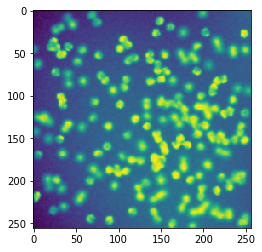

In [55]:
plot_map(np_dataset_x_test[0], "output_img/image0.png")

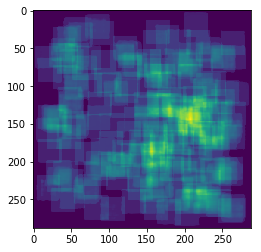

In [56]:
plot_map(pred[0], "output_img/prediction0.png")

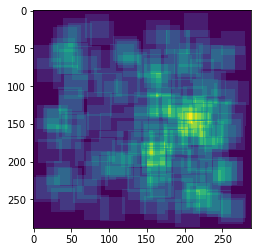

In [57]:
plot_map(np_dataset_y_test[0], "output_img/groundtruth0.png")

In [8]:
datasetfilename = str(scale) + "-" + str(patch_size) + "-" + str(framesize) + "-" + str(stride) + "-" + kernel + "-our_1024-dataset.p"

img_file_path = []
for filename in glob.iglob('ours_1024/*image.jpg'):
    xml = filename.split("image.jpg")[0] + "dots.jpg"
    img_file_path.append([filename, xml])

In [9]:
new_x, new_y, new_c = data_process(datasetfilename, img_file_path, verbose = True)

total number of images:  1
input image raw shape (1024, 1024)  ->>>> (1024, 1024)


/home/xywang/.local/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/xywang/.local/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


TypeError: only size-1 arrays can be converted to Python scalars

In [8]:
datasetfilename = str(scale) + "-" + str(patch_size) + "-" + str(framesize) + "-" + str(stride) + "-" + kernel + "-our_256-dataset.p"

img_file_path = []
for filename in glob.iglob('ours_256/*image.jpg'):
    xml = filename.split("image.jpg")[0] + "dots.jpg"
    img_file_path.append([filename, xml])

In [9]:
new_x, new_y, new_c = data_process(datasetfilename, img_file_path, verbose = True)

total number of images:  1
input image raw shape (256, 256)  ->>>> (256, 256)


/home/xywang/.local/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/xywang/.local/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


count  [0] ==? lab_est [0]
save data to a binary file:  1-32-256-1-sq-our_256-dataset.p
image data shape:  (1, 256, 256, 1)
ground truth data shape (1, 288, 288, 1)
count data shape (1, 1)
